In [38]:
import json, random, time
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import os
import re
from nltk.corpus import stopwords
import pickle
import pylcs
np.set_printoptions(precision=4)

In [2]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0725.json", "r"))
img_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_0725.json", "r"))

In [60]:
splits = ['train']*7 + ['val', 'ind_test', 'ood_test']
txt_dataset_0725_random_split = copy.deepcopy(txt_dataset)
for k in txt_dataset_0725_random_split:
    txt_dataset_0725_random_split[k]['split'] = random.choice(splits)
print(Counter([txt_dataset_0725_random_split[k]['split'] for k in txt_dataset_0725_random_split]))
#json.dump(txt_dataset_0725_random_split, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0725_random_split.json", "w"), indent=4)

Counter({'train': 5647, 'ind_test': 793, 'ood_test': 742, 'val': 739})


In [4]:
img_meta = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data/img_metadata-Copy1.json", "r"))

### Length Distribution

In [5]:
### Comparison of length distribution of img captions: 
# with pos imgs || with neg imgs for img data || with neg imgs for txt data
cap_lengths = {'pos_imgs': [], 'neg_imgs_for_img': [], 'neg_imgs_for_txt': []}
for k in img_dataset:
    for gid in img_dataset[k]['GoldIds']:
        i = str(int(gid))
        cap_lengths['pos_imgs'].append(len(tokenizer.tokenize((img_meta[i]['name']+' '+img_meta[i]['description']).replace("_", " ").strip())))
    for gid in img_dataset[k]['DistractorIds']:
        i = str(int(gid))
        cap_lengths['neg_imgs_for_img'].append(len(tokenizer.tokenize((img_meta[i]['name']+' '+img_meta[i]['description']).replace("_", " ").strip())))
for k in txt_dataset:
    for i in txt_dataset[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_txt'].append(len(tokenizer.tokenize(i['caption'].strip())))
        
for k in cap_lengths:
    print(k, len(cap_lengths[k]))

pos_imgs 36597
neg_imgs_for_img 752251
neg_imgs_for_txt 157029


In [87]:
for k in cap_lengths:
    print(k)
    print(Counter(cap_lengths[k]))

pos_imgs
Counter({7: 2864, 8: 2684, 6: 2677, 9: 2638, 5: 2419, 10: 2398, 11: 2176, 12: 2048, 13: 1835, 4: 1788, 14: 1545, 15: 1436, 3: 1165, 16: 1145, 17: 1102, 18: 984, 20: 706, 19: 691, 21: 588, 22: 471, 23: 445, 2: 385, 24: 333, 25: 319, 26: 254, 27: 203, 29: 172, 28: 161, 31: 118, 30: 117, 32: 107, 33: 64, 35: 64, 34: 60, 36: 53, 38: 46, 37: 45, 42: 39, 39: 35, 40: 32, 41: 25, 43: 22, 46: 19, 45: 19, 44: 17, 48: 10, 47: 8, 50: 7, 51: 6, 1: 6, 59: 6, 60: 5, 58: 5, 56: 4, 49: 4, 55: 4, 54: 3, 57: 2, 73: 2, 67: 2, 52: 2, 83: 1, 69: 1, 61: 1, 91: 1, 65: 1, 53: 1, 75: 1})
neg_imgs_for_img
Counter({8: 41713, 9: 40853, 10: 40381, 7: 40351, 11: 39044, 6: 37493, 12: 36688, 13: 35378, 14: 33810, 15: 30780, 5: 30462, 16: 28776, 17: 26039, 4: 23981, 18: 23484, 19: 21003, 20: 19141, 21: 17046, 3: 15858, 22: 15191, 23: 13705, 24: 12004, 25: 10877, 26: 10016, 27: 8604, 28: 7716, 29: 6921, 30: 6181, 2: 5707, 31: 5409, 32: 5139, 33: 4568, 34: 4183, 35: 4071, 36: 3539, 37: 3153, 38: 3127, 39: 2736, 

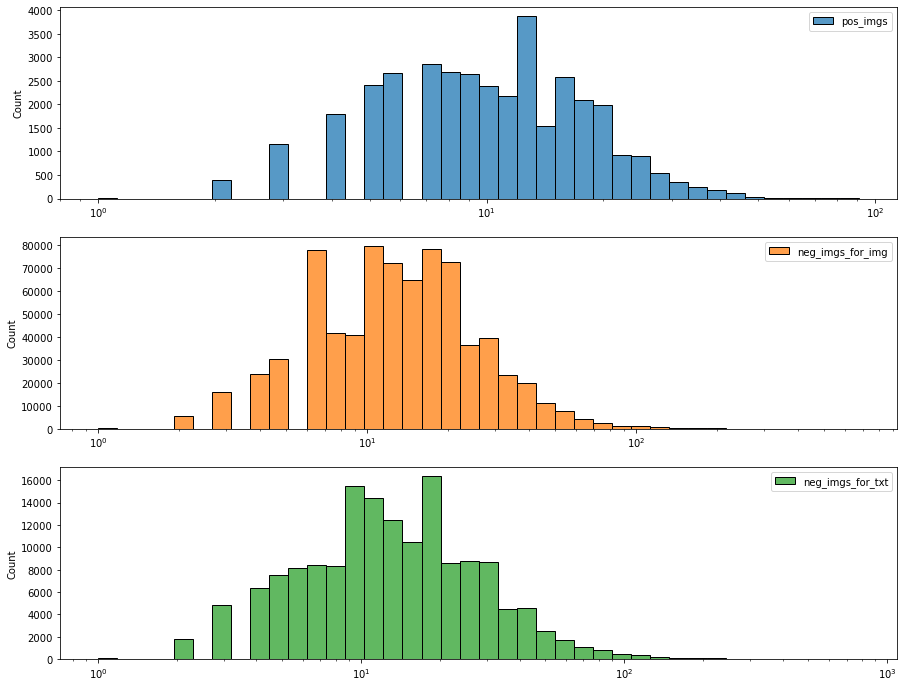

In [81]:
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(cap_lengths.keys()), colors[:3]):
    ax = axes[i]
    ax.set(xscale="log")
    sns.histplot(cap_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

In [29]:
for k in cap_lengths:
    print(k, np.mean(cap_lengths[k]), np.std(cap_lengths[k]))

pos_imgs 11.808508894171654 7.150573026092369
neg_imgs_for_img 16.434307166092168 14.222141898446292
neg_imgs_for_txt 17.679059282043443 18.14455315282661


In [35]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'pos_snippets': [], 'neg_snippets_for_img': [], 'neg_snippets_for_txt': []}
for k in txt_dataset:
    for f in txt_dataset[k]['SupportingFacts']:
        snippet_lengths['pos_snippets'].append(len(tokenizer.tokenize(f['fact'])))
    for f in txt_dataset[k]['new_negFacts']:
        snippet_lengths['neg_snippets_for_txt'].append(len(tokenizer.tokenize(f['fact'])))
for k in img_dataset:
    for f in img_dataset[k]['DistractorFacts']:
        snippet_lengths['neg_snippets_for_img'].append(len(tokenizer.tokenize(f['fact'])))
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))

pos_snippets 16125
neg_snippets_for_img 911053
neg_snippets_for_txt 276162


In [36]:
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))

pos_snippets 60.054077519379845 14.810770948435264
neg_snippets_for_img 43.288029346261965 12.957218301785035
neg_snippets_for_txt 42.55756765956214 12.752168500660586


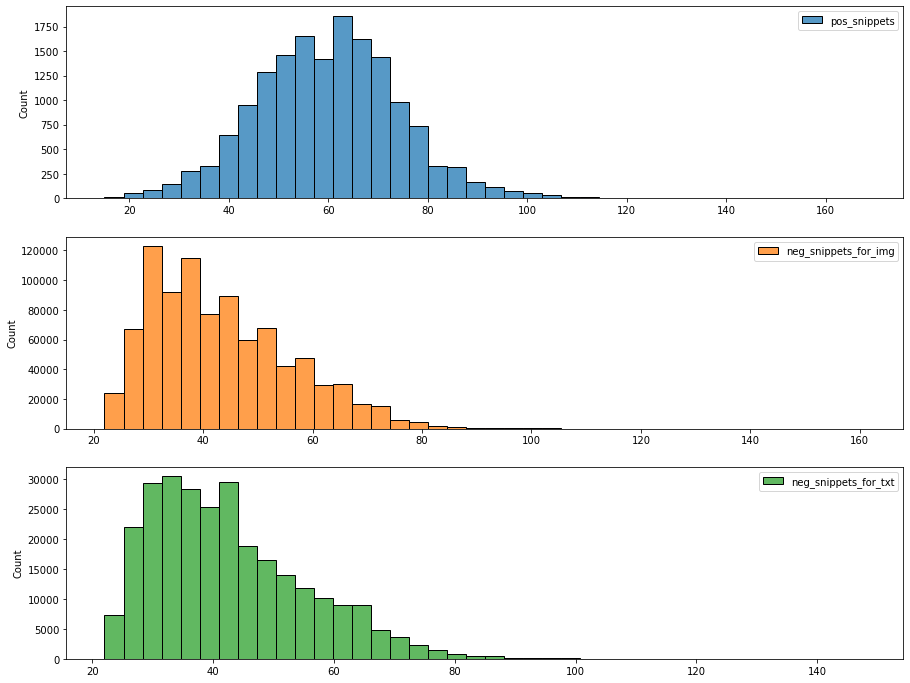

In [46]:
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(snippet_lengths.keys()), colors[:3]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

### Performance of Overlap Strategy

In [39]:
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

In [40]:
# For the purpose of measuring token-level overlap
### Processing: only did stopwords removal + tokenization
def compute_vqa_metrics(cands, a):
    if len(cands) == 0: return (0,0,0)
    remove_stop_a = pattern.sub('', a)
    bow_a = tokenizer.tokenize(remove_stop_a) #normalize_text(a).split()
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        remove_stop_c = pattern.sub('', c)
        bow_c = tokenizer.tokenize(remove_stop_c) #normalize_text(c).split()
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg)

In [49]:
# For each sample, compute overlap metrics between Q and all facts respectively

guid2posMetrics = defaultdict(lambda: defaultdict(lambda: []))
guid2negMetrics = defaultdict(lambda: defaultdict(lambda: []))
zero_pos = 0
count = 0
for k in txt_dataset:
    count += 1
    if count%1000 == 0: print(k)
    q = txt_dataset[k]['Q']
    guid = txt_dataset[k]['Guid']
    if len(txt_dataset[k]['SupportingFacts']) == 0: 
        zero_pos += 1
        continue
    for f in txt_dataset[k]['SupportingFacts']:
        F1, _, __, RE, PR = compute_vqa_metrics([f['fact']], q)
        lcs = pylcs.lcs2(q, f['fact'])
        lcs_f = lcs / len(f['fact'])
        lcs_q = lcs / len(q)
        guid2posMetrics[guid]['F1'].append(F1)
        guid2posMetrics[guid]['RE'].append(RE)
        guid2posMetrics[guid]['PR'].append(PR)
        guid2posMetrics[guid]['lcs_q'].append(lcs_q)
        guid2posMetrics[guid]['lcs_f'].append(lcs_f)
        
    for d in txt_dataset[k]['DistractorFacts'] + txt_dataset[k]['new_negFacts']:
        F1, _, __, RE, PR = compute_vqa_metrics([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        guid2negMetrics[guid]['F1'].append(F1)
        guid2negMetrics[guid]['RE'].append(RE)
        guid2negMetrics[guid]['PR'].append(PR)
        guid2negMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negMetrics[guid]['lcs_f'].append(lcs_f)
assert set(guid2posMetrics.keys()) == set(guid2negMetrics.keys())
print(zero_pos)

78
2078
3078
5078
1078
6078
4078
0


In [80]:
# For each sample, compute overlap metrics between Q and all facts respectively

guid2negImgMetrics = defaultdict(lambda: defaultdict(lambda: []))
zero_pos = 0
count = 0
for k in txt_dataset:
    count += 1
    if count%1000 == 0: print(k)
    q = txt_dataset[k]['Q']
    guid = txt_dataset[k]['Guid']
        
    for d in txt_dataset[k]['img_negFacts']:
        F1, _, __, RE, PR = compute_vqa_metrics([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2negImgMetrics[guid]['F1'].append(F1)
        guid2negImgMetrics[guid]['RE'].append(RE)
        guid2negImgMetrics[guid]['PR'].append(PR)
        guid2negImgMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negImgMetrics[guid]['lcs_f'].append(lcs_f)
assert set(guid2negImgMetrics.keys()) == set(guid2negImgMetrics.keys())
print(zero_pos)

78
2078
3078
5078
1078
6078
4078
0


In [78]:
# Merge DistractorFacts & new_negFacts
# Rerank them by overlap scores (RE), cuz RE is the most indicative of correctness
txt_dataset_0725_ranked_by_RE = copy.deepcopy(txt_dataset_0725_random_split)

count = 0
for k in txt_dataset:
    count += 1
    if count%1000 == 0: print(k)
    q = txt_dataset[k]['Q']
    
    distractors = []
    for d in txt_dataset[k]['DistractorFacts'] + txt_dataset[k]['new_negFacts']:
        upd_d = copy.deepcopy(d)
        F1, _, __, RE, PR = compute_vqa_metrics([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        upd_d['overlap_scores'] = (round(F1, 4), round(RE, 4), round(PR, 4), round(lcs_q, 4), round(lcs_f, 4))
        distractors.append(upd_d)
    distractors = list(sorted(distractors, key=lambda x: x['overlap_scores'][1], reverse=True))
    for upd_d in distractors:
        upd_d['overlap_scores'] = str(upd_d['overlap_scores'])
    txt_dataset_0725_ranked_by_RE[k]['new_negFacts'] = distractors
    del txt_dataset_0725_ranked_by_RE[k]['DistractorFacts']
print(len(txt_dataset_0725_ranked_by_RE))
json.dump(txt_dataset_0725_ranked_by_RE, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0725_ranked_by_RE.json", "w"), indent=4)

78
2078
3078
5078
1078
6078
4078
7921


F1 0.0789041787653074
RE 0.14695114253250852
PR 0.033076631738416865
lcs_q 0.13066532003534906
lcs_f 0.041661406388082314


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


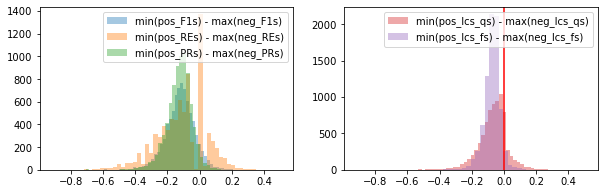

In [51]:
# posdominate
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [min(guid2posMetrics[guid][m]) - max(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="min(pos_{}s) - max(neg_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [min(guid2posMetrics[guid][m]) - max(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="min(pos_{}s) - max(neg_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

F1 0.8074738038126499
RE 0.9351092033834112


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


PR 0.7139250094685015
lcs_q 0.9069561923999495
lcs_f 0.6677187223835375


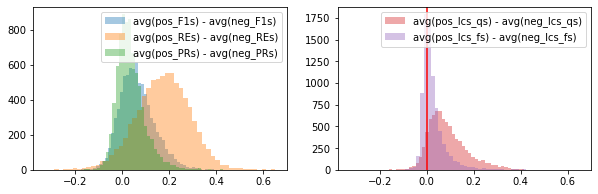

In [52]:
# avg(pos) - avg(neg)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


F1 0.5942431511172832
RE 0.9551824264613054
PR 0.19492488322181542
lcs_q 0.9340992298952152
lcs_f 0.0944325211463199


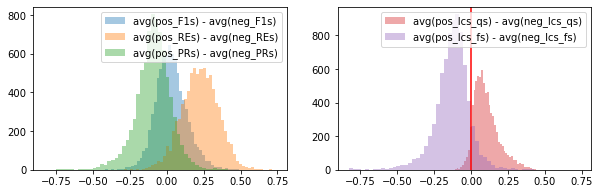

In [82]:
# avg(pos) - avg(neg_Img)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negImgMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negImgMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

F1 0.22825400833228127
RE 0.4537305895720237


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


PR 0.12069183183941422
lcs_q 0.4095442494634516
lcs_f 0.16058578462315365


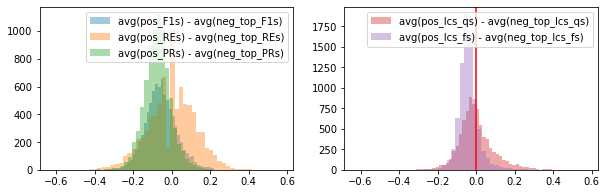

In [53]:
# avg(pos) - avg(neg_top)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


F1 0.25047342507259185
RE 0.7783108193409923
PR 0.03812649917939654
lcs_q 0.6452468122711779
lcs_f 0.023986870344653452


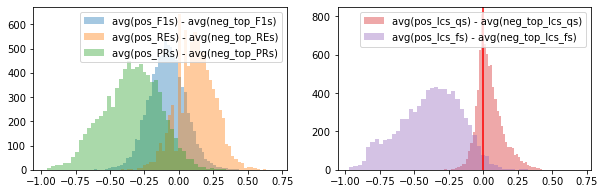

In [84]:
# avg(pos) - avg(negImg_top)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negImgMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negImgMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

In [54]:
def compute_retrieval_metrics(pred, gth):
    common = len(set(pred).intersection(gth))
    RE = common / len(gth)
    PR = common / len(pred)
    F1 = 2*PR*RE / (PR + RE + 1e-5)
    return F1, RE, PR

In [55]:
# Performance of top2<m> strategy (on pure txt distractors)
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for guid in guid2posMetrics:
        f_scores = guid2posMetrics[guid][m]
        all_scores = np.array(f_scores + guid2negMetrics[guid][m])
        pred = all_scores.argsort()[-2:][::-1]
        gth = range(len(guid2posMetrics[guid][m]))
        F1, RE, PR = compute_retrieval_metrics(pred, gth)
        F1s.append(F1)
        REs.append(RE)
        PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

F1
   F1 =  0.28550441917011576
   RE =  0.28418129024113115
   PR =  0.28758995076379246
RE
   F1 =  0.529891187501893
   RE =  0.5274796953246644
   PR =  0.5336447418255271
PR
   F1 =  0.18257209266960808
   RE =  0.18174262508942474
   PR =  0.18387829819467238
lcs_q
   F1 =  0.4230871502601948
   RE =  0.4210011362201742
   PR =  0.426335058704709
lcs_f
   F1 =  0.18715062876627744
   RE =  0.1862243824432942
   PR =  0.18861254892059084


In [85]:
# Performance of top2<m> strategy (pos snippets vs. negImg captions)
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for guid in guid2posMetrics:
        f_scores = guid2posMetrics[guid][m]
        all_scores = np.array(f_scores + guid2negImgMetrics[guid][m])
        pred = all_scores.argsort()[-2:][::-1]
        gth = range(len(guid2posMetrics[guid][m]))
        F1, RE, PR = compute_retrieval_metrics(pred, gth)
        F1s.append(F1)
        REs.append(RE)
        PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

F1
   F1 =  0.2776942078269814
   RE =  0.27641711905062494
   PR =  0.27969953288726174
RE
   F1 =  0.72076294859492
   RE =  0.7173336699911628
   PR =  0.726107814669865
PR
   F1 =  0.06422535234826063
   RE =  0.06393342591423641
   PR =  0.06470142658755208
lcs_q
   F1 =  0.5946892137692152
   RE =  0.5919286285401674
   PR =  0.5989774018432016
lcs_f
   F1 =  0.044977096888104244
   RE =  0.04483861465303202
   PR =  0.04519631359676809


In [86]:
# Performance of top2<m> strategy (pos snippets vs. [neg snippets + negImg captions])
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for guid in guid2posMetrics:
        f_scores = guid2posMetrics[guid][m]
        all_scores = np.array(f_scores + guid2negImgMetrics[guid][m] + guid2negMetrics[guid][m])
        pred = all_scores.argsort()[-2:][::-1]
        gth = range(len(guid2posMetrics[guid][m]))
        F1, RE, PR = compute_retrieval_metrics(pred, gth)
        F1s.append(F1)
        REs.append(RE)
        PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

F1
   F1 =  0.18340534735362915
   RE =  0.18262635189159618
   PR =  0.18463577831081934
RE
   F1 =  0.5141230359861281
   RE =  0.5119197912721458
   PR =  0.5175482893574044
PR
   F1 =  0.03831971006546816
   RE =  0.03812649917939654
   PR =  0.03863148592349451
lcs_q
   F1 =  0.3971604288072799
   RE =  0.39533097672852757
   PR =  0.40001262466860243
lcs_f
   F1 =  0.030185291859947377
   RE =  0.03010983461684131
   PR =  0.030299204645878045


In [58]:
for guid in guid2negMetrics:
    if random.random() < 0.002:
        for m in guid2negMetrics[guid]:
            print(m, guid2posMetrics[guid][m])
            print(m, guid2negMetrics[guid][m])
        print('\n ----------------------- ')

F1 [0.38461144974439876, 0.11110848401273356]
F1 [0.1403471715352077, 0.1034446136849408, 0.3508734872659766, 0.189186121306141, 0.1568587621157463, 0.15384355033991734, 0.0563348623084421, 0.11267289038850246, 0.3243196202289318, 0.22726838851258294, 0.25531496611651255, 0.22856662867222644, 0.23529013463105433, 0.23999596806773646, 0.21621151215493825, 0.13792604060887448, 0.23255374805480425, 0.14633696622981832, 0.11764221473233455, 0.09999545020701558, 0.11764307587494752, 0.19999545010351016, 0.17856767865017692, 0.27999596805806, 0.1538422190355516, 0.21738707002576646, 0.1142809144873058, 0.21738707002576646, 0.25925541843824534, 0.1960744483700292, 0.17020858317205184, 0.16393088962211896, 0.10255950053523238, 0.2380907937337551, 0.1403471715352077, 0.09090475227318696, 0.2641470559489879, 0.16948790585150214, 0.03508401393396697, 0.15872670201531483, 0.14705555370592346, 0.1403471715352077, 0.2580610198184412, 0.07406908126933666, 0.11764307587494752, 0.10713910727410254, 0.0